In [1]:
import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
import random
from collections import defaultdict
from glob import glob

/home/shizm/DL_LABs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.listdir('/home/shizm/kaggle/input/dl-lab-1-image-classification')

['train.csv',
 'train',
 'test_images_clear',
 'test.csv',
 'test_images',
 'train_noncleared',
 'sample_submission.csv']

In [5]:
# важно - зафиксировать все сиды
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
class_to_idx = { "Апельсин": 0, "Бананы": 1, "Груши": 2, "Кабачки": 3, "Капуста": 4, "Картофель": 5, "Киви": 6, "Лимон": 7, "Лук": 8, "Мандарины": 9, "Морковь": 10, "Огурцы": 11, "Томаты": 12, "Яблоки зелёные": 13, "Яблоки красные": 14 }

In [7]:
class MyDataset(Dataset):
    def __init__(self, images_filepaths, name2label, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.name2label = name2label

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imdecode(np.fromfile(image_filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.name2label[os.path.normpath(image_filepath).split(os.sep)[-3]]
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label


def train_test_split_from_directory(root_path, folder2class, train_size=0.8):
    train, test = [], []
    class_to_images = defaultdict(list)

    for class_name in os.listdir(root_path):
        class_path = os.path.join(root_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for subclass_name in os.listdir(class_path):
            subclass_path = os.path.join(class_path, subclass_name)
            if not os.path.isdir(subclass_path):
                continue

            # Глобальный класс = имя первой папки (class_name)
            class_name = folder2class.get(class_name, class_name)

            images = glob(os.path.join(subclass_path, '*.jpg')) + \
                     glob(os.path.join(subclass_path, '*.png')) + \
                     glob(os.path.join(subclass_path, '*.jpeg'))

            class_to_images[class_name].extend(images)

    # Равномерное разбиение по каждому классу
    for cls_name, images in class_to_images.items():
        random.shuffle(images)
        split_idx = int(train_size * len(images))
        train.extend(images[:split_idx])
        test.extend(images[split_idx:])

    return train, test


In [9]:
dataset_path = '/home/shizm/kaggle/input/dl-lab-1-image-classification/train/train'
train, test = train_test_split_from_directory(dataset_path, class_to_idx)

# Посмотрим на распределение данных

In [10]:
from collections import Counter
import os

def count_classes(image_paths, class_to_idx):
    counts = Counter()
    for path in image_paths:
        class_name = os.path.normpath(path).split(os.sep)[-3]
        class_idx = class_to_idx[class_name]
        counts[class_idx] += 1
    return counts

train_counts = count_classes(train, class_to_idx)
test_counts  = count_classes(test, class_to_idx)


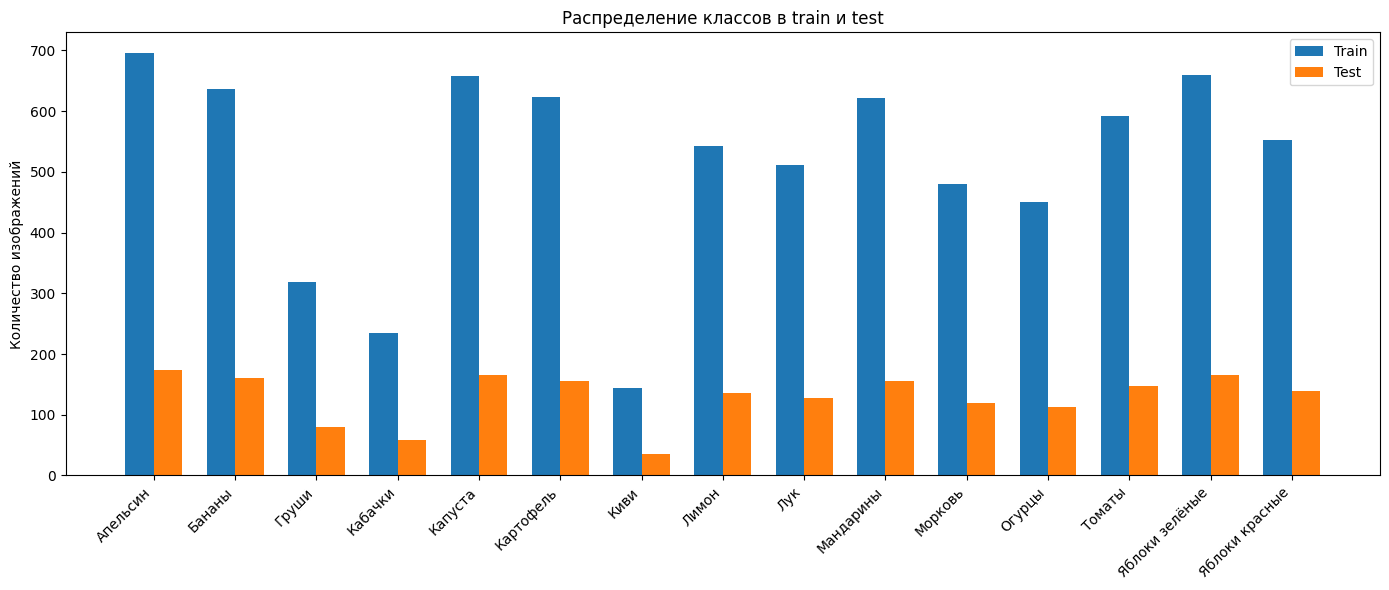

In [11]:
import matplotlib.pyplot as plt
import numpy as np

idx2class = {v: k for k, v in class_to_idx.items()}

classes = list(idx2class.keys())
class_names = [idx2class[i] for i in classes]

train_values = [train_counts.get(i, 0) for i in classes]
test_values  = [test_counts.get(i, 0) for i in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, test_values,  width, label='Test')

plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в train и test')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

rows = []

for class_idx, class_name in idx2class.items():
    train_cnt = train_counts.get(class_idx, 0)
    test_cnt  = test_counts.get(class_idx, 0)
    total     = train_cnt + test_cnt

    test_ratio = test_cnt / total if total > 0 else 0

    rows.append({
        "Класс": class_name,
        "Train": train_cnt,
        "Test": test_cnt,
        "Total": total,
        "Test %": round(test_ratio * 100, 2)
    })

df = pd.DataFrame(rows)
df


,Класс,Train,Test,Total,Test %
0,Апельсин,695,174,869,20.02
1,Бананы,636,160,796,20.10
2,Груши,319,80,399,20.05
3,Кабачки,235,59,294,20.07
4,Капуста,658,165,823,20.05
5,Картофель,624,156,780,20.00
6,Киви,144,36,180,20.00
7,Лимон,542,136,678,20.06
8,Лук,512,128,640,20.00
9,Мандарины,621,156,777,20.08


# Вернёмся к обучению

### Аугментации - базовая техника для увеличения набора данных

In [13]:
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

# Validation transforms - deterministic
val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

In [ ]:
train_dataset = MyDataset(images_filepaths=train, name2label=class_to_idx, transform=train_transforms)
test_dataset = MyDataset(images_filepaths=test, name2label=class_to_idx, transform=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,  # Parallel loading
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True  # Keep workers alive
)
test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=1,  # Parallel loading
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

In [17]:
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device, desc="Val"):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(dataloader, desc=desc, leave=False)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size

        y_pred = logits.argmax(dim=1)
        total_correct += (y_pred == y_batch).sum().item()
        total_samples += batch_size

        avg_loss = total_loss / max(total_samples, 1)
        acc = total_correct / max(total_samples, 1)
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.4f}")

    avg_loss = total_loss / max(total_samples, 1)
    accuracy = total_correct / max(total_samples, 1)
    return accuracy, avg_loss


def train(model, loss_fn, optimizer, train_loader, val_loader, device, writer=None, n_epoch=3):
    num_iter = 0

    for epoch in range(1, n_epoch + 1):
        model.train()

        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epoch}", leave=True)

        for X_batch, y_batch in pbar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # накопим метрики для прогресс-бара
            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            y_pred = logits.argmax(dim=1)
            total_correct += (y_pred == y_batch).sum().item()

            avg_loss = total_loss / max(total_samples, 1)
            acc = total_correct / max(total_samples, 1)

            # tqdm live-metrics
            pbar.set_postfix(train_loss=f"{avg_loss:.4f}", train_acc=f"{acc:.4f}")

            # логирование (по итерациям)
            num_iter += 1
            if writer is not None:
                writer.add_scalar("Loss/train", loss.item(), num_iter)
                writer.add_scalar("Accuracy/train", (y_pred == y_batch).float().mean().item(), num_iter)

        # Валидация (тоже с tqdm)
        val_acc, val_loss = evaluate(model, val_loader, loss_fn, device, desc=f"Val {epoch}/{n_epoch}")

        if writer is not None:
            writer.add_scalar("Loss/val", val_loss, num_iter)
            writer.add_scalar("Accuracy/val", val_acc, num_iter)

        print(f"Epoch {epoch}/{n_epoch}: val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

    return model


## Три основные составляющие любого обучения:
### 1) Модель
### 2) Функция ошибок (loss function)
### 3) Оптимизатор

In [18]:
model = timm.create_model('resnet50', pretrained=True, num_classes=15)
model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model = train(model, loss_fn, optimizer, train_loader, test_loader, device, writer, n_epoch=10)

Epoch 1/10: 100%|██████████| 242/242 [00:40<00:00,  6.02it/s, train_acc=0.2492, train_loss=2.3970]


Epoch 1/10: val_loss=1.6462  val_acc=0.5194


Epoch 2/10: 100%|██████████| 242/242 [00:39<00:00,  6.10it/s, train_acc=0.5173, train_loss=1.5459]


Epoch 2/10: val_loss=0.9131  val_acc=0.7297


Epoch 3/10: 100%|██████████| 242/242 [00:39<00:00,  6.12it/s, train_acc=0.6310, train_loss=1.1348]


Epoch 3/10: val_loss=0.6351  val_acc=0.8202


Epoch 4/10: 100%|██████████| 242/242 [00:39<00:00,  6.08it/s, train_acc=0.6971, train_loss=0.9126]


Epoch 4/10: val_loss=0.4946  val_acc=0.8450


Epoch 5/10: 100%|██████████| 242/242 [00:39<00:00,  6.05it/s, train_acc=0.7333, train_loss=0.7966]


Epoch 5/10: val_loss=0.4237  val_acc=0.8677


Epoch 6/10: 100%|██████████| 242/242 [00:40<00:00,  6.05it/s, train_acc=0.7614, train_loss=0.7145]


Epoch 6/10: val_loss=0.3792  val_acc=0.8894


Epoch 7/10: 100%|██████████| 242/242 [00:39<00:00,  6.06it/s, train_acc=0.7841, train_loss=0.6444]


Epoch 7/10: val_loss=0.3487  val_acc=0.8873


Epoch 8/10: 100%|██████████| 242/242 [00:39<00:00,  6.06it/s, train_acc=0.8082, train_loss=0.5685]


Epoch 8/10: val_loss=0.3339  val_acc=0.8966


Epoch 9/10: 100%|██████████| 242/242 [00:39<00:00,  6.07it/s, train_acc=0.8220, train_loss=0.5329]


Epoch 9/10: val_loss=0.3037  val_acc=0.9070


Epoch 10/10: 100%|██████████| 242/242 [00:39<00:00,  6.07it/s, train_acc=0.8399, train_loss=0.4837]


Epoch 10/10: val_loss=0.2872  val_acc=0.9121


# Посмотрим на итоговые метрики

In [20]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def sklearn_report(model, dataloader, device, idx2class=None, digits=4):
    model.eval()

    y_true, y_pred = [], []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device, non_blocking=True)

        logits = model(X_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred.append(preds)
        y_true.append(y_batch.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # names for report
    if idx2class is None:
        target_names = None
        labels = None
    else:
        labels = sorted(idx2class.keys())
        target_names = [idx2class[i] for i in labels]

    rep = classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        digits=digits,
        zero_division=0
    )
    print(rep)

In [21]:
sklearn_report(model, test_loader, device, idx2class=idx2class)

                precision    recall  f1-score   support

      Апельсин     0.9231    0.9655    0.9438       174
        Бананы     0.9064    0.9688    0.9366       160
         Груши     0.8667    0.6500    0.7429        80
       Кабачки     0.9123    0.8814    0.8966        59
       Капуста     0.9877    0.9758    0.9817       165
     Картофель     0.8452    0.8397    0.8424       156
          Киви     0.6977    0.8333    0.7595        36
         Лимон     0.9394    0.9118    0.9254       136
           Лук     0.8473    0.8672    0.8571       128
     Мандарины     0.9363    0.9423    0.9393       156
       Морковь     0.9333    0.9333    0.9333       120
        Огурцы     0.9328    0.9823    0.9569       113
        Томаты     0.9640    0.9054    0.9338       148
Яблоки зелёные     0.9148    0.9758    0.9443       165
Яблоки красные     0.8923    0.8345    0.8625       139

      accuracy                         0.9121      1935
     macro avg     0.9000    0.8978    0.8971 

# Оформляем предсказание

In [24]:
test_images_dir = "/home/shizm/kaggle/input/dl-lab-1-image-classification/test_images/test_images"
submission_path = "/home/shizm/kaggle/input/dl-lab-1-image-classification/sample_submission.csv"
output_path = "submission.csv"

In [25]:
submission = pd.read_csv(submission_path)

model.eval()
pred_labels = []

with torch.no_grad():
    for image_id in tqdm(submission["image_id"], desc="Predicting"):
        image_path = os.path.join(test_images_dir, image_id)

        image = cv2.imdecode(
            np.fromfile(image_path, dtype=np.uint8),
            cv2.IMREAD_COLOR
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Когда мы хотим сделать предсказание, нам нужно знать, а какие были преобразования при обучении/тестировании
        if val_transforms is not None:
            image = val_transforms(image=image)["image"]

        image = image.unsqueeze(0).to(device)

        logits = model(image)
        pred_idx = logits.argmax(dim=1).item()

        pred_labels.append(pred_idx)


Predicting: 100%|██████████| 2503/2503 [00:12<00:00, 200.24it/s]


In [26]:
submission["label"] = pred_labels
submission.to_csv(output_path, index=False)

submission.head()


,image_id,label
0,fd343552326b42c5a62c192f32549dc7.jpg,8
1,445ca69812cf44f581cc8a89223af277.jpg,7
2,570626ce4d8f41edb8088f49d40a2195.jpg,7
3,02d4acba92f343d798adcb4958fe684b.jpg,11
4,2d4b8e8f38534a39b0d02c440e917b83.jpg,12
